In [2]:
# This is Oliver's second attempt at sort of baseline model to predict colexification in CLICS.
# Here, I was trying to predict p(a and b colexify) in a "randomly selected" language. 
# More specifically, I tried doing this by trying to predict the "colex.freq" column divided by the total number of languages in the CLICS.csv file. 
# This is because if a and b colexify 300 times out of 5000 languages, 300/5000 is a good estimate for the probability they colexify in a "random" language
# For the input, I converted the senses of each row to their word2vec embeddings. 
# I used neural networks, XGBoost, and random forest as models

In [3]:
from google.colab import drive
! [ -e /content ] && pip install -Uqq fastbook
! pip install torch-lr-finder
import fastbook
fastbook.setup_book()
from fastai.tabular.all import *

     |████████████████████████████████| 719 kB 6.6 MB/s 
     |████████████████████████████████| 362 kB 55.4 MB/s 
     |████████████████████████████████| 1.2 MB 43.7 MB/s 
     |████████████████████████████████| 4.4 MB 42.3 MB/s 
     |████████████████████████████████| 140 kB 52.6 MB/s 
     |████████████████████████████████| 1.1 MB 40.8 MB/s 
     |████████████████████████████████| 212 kB 46.8 MB/s 
     |████████████████████████████████| 101 kB 10.2 MB/s 
     |████████████████████████████████| 596 kB 53.9 MB/s 
     |████████████████████████████████| 127 kB 51.5 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 144 kB 36.3 MB/s 
     |████████████████████████████████| 271 kB 51.0 MB/s 
     |████████████████████████████████| 6.6 MB 38.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from fastbook import *
import gensim.downloader as gs
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random as r
from torch_lr_finder import LRFinder

In [5]:
wv = gs.load('word2vec-google-news-300') # These are the word2vec embeddings we are using

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [6]:
NUM_LANGUAGE = 3156 # This is the number of languages used in the CLICS database
df = pd.read_csv("gdrive/MyDrive/clics-colexification-data.csv") # Change path as needed
df.head()

,colex.freq,Concepticon_Gloss.xo,Concepticon_Gloss.yo,vision,assoc,affec,tax,fully_covered
0,340,TREE,WOOD,1,1,1,1,1
1,326,LEG,FOOT,1,1,1,1,1
2,296,MOON,MONTH,0,1,1,1,0
3,291,GO,WALK,0,1,1,1,0
4,284,HAND,ARM,1,1,1,1,1


In [7]:
dumb_british_spellings = {"armour":"armor", "grey":"gray", "mould":"mold", "neighbour":"neighbor", "axe":"ax", "moustache":"mustache", "plough":"plow", "mandarine":"mandarin"}
obscure_words = {"shoulderblade":"shoulder blade", "spearthrower":"spear thrower", "ridgepole":"ridge pole", "pimpleface":"pimple face", "tumpline":"backpack", "cushma":"clothing", "curassow":"tropical bird", "banisterium":"plant", "paca":"rodent", "netbag":"net bag", "muntjacs":"barking deer"}

# This converts a sense to its word2vec embeddings. More specifically, for each sense I remove punctuation and then add the vectors of each individual word. 
# I also replace some obscure words and british spellings not recognized by word2vec to similar phrases that word2vec can recognize
def stringToVec(s):  
  s = s.lower()
  for i in "(),\t\n":
    s = s.replace(i, "")
  for i in "-":
    s = s.replace(i, " ")
  for i in dumb_british_spellings:
    s = s.replace(i, dumb_british_spellings[i])
  for i in obscure_words:
    s = s.replace(i, obscure_words[i])
  arr = s.split(" ")
  vec_defined = False
  for i in arr:
    try:      # try except gives an error if we can't convert the 
      if vec_defined:
        vec += np.array(wv[i])
      else:
        vec = np.array(wv[i])
        vec_defined = True
    except:
      continue
  if not vec_defined:
    raise Exception("Word cannot be converted to vector")
  return vec #This will return the string "error" if there is not 
def toTensor(arr):
  return torch.tensor(arr, dtype = torch.float32) #Function to easily convert arrays to tensors

In [8]:
embed_length = len(wv["test"]) # Length of embeddings in word2vec
vec_dic = {} # This will be a dictionary that easily allows us to access the embedding for all of our senses. Note this is not as simple as just calling wv[s] as some senses are phrases
error_senses = set()  # This represents the set of senses for which there was a problem converting them to embeddings. The only such sense should be "AND" as "AND" doesn't appear in word2vec
for i in range(len(df)): # Here we loop through each row of our dataframe, and if we can convert a sense s to an embedding then we set vec_dic[s] = embedding
  row = df.iloc[i]
  x = row["Concepticon_Gloss.xo"]
  y = row["Concepticon_Gloss.yo"]
  try:   
    if x not in vec_dic:
      xvec = stringToVec(x)
      vec_dic[x] = xvec
  except:
    error_senses.add(x)

  try:  
    if y not in vec_dic:
      yvec = stringToVec(y)
      vec_dic[y] = yvec
  except: 
    error_senses.add(y)

error_senses = list(error_senses)
senses = list(vec_dic.keys())

sense_indices = {senses[i]:i for i in range(len(senses))} # sense_indices is a dictionary where its keys are senses and its values are the indices for which the senses appear in our list of senses

In [9]:
# Here we set up the dependent variables - probability distributions p(?|s) for each sense s, where p(a|b) is (roughly) proportional to how frequently they are colexified in our data set.  

# I added a small epsilon term of 0.00001, so the probabilities p(b|a) for are not actually proportional to the colexification frequency
# of a and b, but are proportional to colex.freq + epsilon. The reason for this is if a and b don't appear as colexified in our 
# data set, there is probably a very small but not actually zero probability they colexify
# Thus, this epsilon term "smooths" our probability distributions

epsilon = 0.00001
senseToProbVec = {} # This is a dictionary with keys of senses a and values of lists representing the probability distributions p(?|a). More specifically, if sense_indices[s] = i, then the ith element of senseToProbVec[a] is p(s|a)
for s in senses:
  senseToProbVec[s] = []
  for s2 in senses:
    senseToProbVec[s].append(epsilon)
for i in range(len(df)): # Here we initialize the vectors senseToProvVec[a] so that their ith element is colex.freq of a and the ith sense + epsilon. 
  row = df.iloc[i]
  x = row["Concepticon_Gloss.xo"]
  y = row["Concepticon_Gloss.yo"]
  amt = int(row["colex.freq"])
  if x in vec_dic and y in vec_dic:
    senseToProbVec[x][sense_indices[y]] += amt
    senseToProbVec[y][sense_indices[x]] += amt 
for i in senses:
  senseToProbVec[i] = np.array(senseToProbVec[i])
  senseToProbVec[i] = toTensor(senseToProbVec[i]/sum(senseToProbVec[i])) # Here we normalize the vectors to have sums 1

In [11]:
# This is our neural network. 
# This model recieves an input of a vector representing a word or phrase s in word2vec.
# It outputs a vector predicting the probability distributions p(?|s) 
# We add a dropout layer to prevent overfitting. We output the logs of the probabilities instead of the probabilities since these are used in our KL Divergence loss function.

colex_model_2 = nn.Sequential(
    nn.Linear(embed_length, 500),
    nn.Sigmoid(),
    nn.Linear(500, 500),
    nn.Sigmoid(),
    nn.Linear(500, len(senses)), 
    nn.Dropout(p=0.5), 
    nn.LogSoftmax()
)

In [12]:
# Here we set up batches of training and test data

input_output_pairs = list(zip([toTensor(vec_dic[s]) for s in senses],  [senseToProbVec[s] for s in senses]))
train, test = train_test_split(input_output_pairs, test_size = 0.2, random_state = 0)

X_train = torch.stack([i[0] for i in train])
y_train = torch.stack([i[1] for i in train])
X_test = torch.stack([i[0] for i in test])
y_test = torch.stack([i[1] for i in test])

trainDL = DataLoader(TensorDataset(X_train,y_train), batch_size = 128)
testDL = DataLoader(TensorDataset(X_test,y_test), batch_size = 128)
dls = DataLoaders(trainDL, testDL)


# Learner is a class in FastAI that does all our model training steps for us
# To compare the difference between the probability distributions p(?|a) given by our csv file and the one our model outputs, we use Kullback Leibler divergence
# This measures the "distance" between two probability distributions

learner = Learner(dls, colex_model_2, loss_func = nn.KLDivLoss(reduction = "batchmean"))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


SuggestedLRs(valley=0.0010000000474974513)

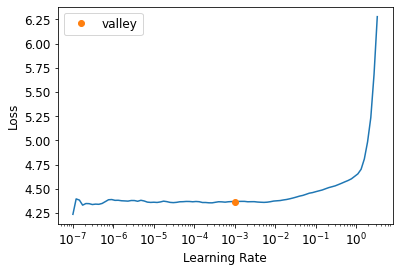

In [15]:
# This is a function in fastai that gives you the best learning rate for a model

learner.lr_find()

In [19]:
# Trains model for 100 epochs

learner.fit_one_cycle(10, 0.001)

epoch,train_loss,valid_loss,time
0,3.821033,4.326914,00:01
1,3.831506,4.328981,00:01
2,3.864056,4.333940,00:01
3,3.854004,4.328362,00:01
4,3.847218,4.323696,00:01
5,3.823710,4.315085,00:01
6,3.808073,4.307692,00:01
7,3.797514,4.303915,00:01
8,3.783219,4.302636,00:01
9,3.764419,4.302392,00:01


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [22]:
# For a given string a (does not have to be a sense), this returns a sorted array of pairs (p(s|a), s) given by inputting a to our model. 
# Thus, the first element of the array will be the sense that our model thinks a is most likely to colexify with

def getHighestProb(word, model):   
  dist = model(toTensor(wv[word.lower()]))
  probs_senses = [(math.exp(float(dist[i].data)), senses[i]) for i in range(len(senses))]
  probs_senses.sort(reverse = True)
  return [i[1] for i in probs_senses]


print("Highest probability senses to colexify with fantasy: ", getHighestProb("fantasy", colex_model_2)[:5])
print("Highest probability senses to colexify with maze: ", getHighestProb("maze", colex_model_2)[:5])
print("Highest probability senses to colexify with orthogonal: ", getHighestProb("orthogonal", colex_model_2)[:5])
print("Highest probability senses to colexify with judicial: ", getHighestProb("judicial", colex_model_2)[:5])
print("Highest probability senses to colexify with milky: ", getHighestProb("milky",colex_model_2)[:5])

Highest probability senses to colexify with fantasy:  ['MIND', 'THOUGHT', 'MESSAGE', 'SPIRIT', 'SHADE']
Highest probability senses to colexify with maze:  ['STONE', 'STONE OR ROCK', 'MIRROR', 'PINE', 'NEST']
Highest probability senses to colexify with orthogonal:  ['LIGHTNING', 'DRUNK', 'TREE (CLASSIFIER)', 'ONE TIME', 'HEIGHT']
Highest probability senses to colexify with judicial:  ['JUDGMENT', 'ADJUDICATE', 'CONDEMN', 'GUARD', 'PROMISE']
Highest probability senses to colexify with milky:  ['LIGHTNING', 'YELLOW', 'FINGER', 'BRACKISH', 'THICK']


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
